## Plot filter evolution

For a given `wandb` run, download the filter parameters, and plot the filter evolution during training

In [1]:
import wandb
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
from learnable_wavelets.scattering.create_filters import morlets
from learnable_wavelets.scattering.scattering2d import scattering2d_learn
from learnable_wavelets.models.models_factory import baseModelFactory

/mnt/home/cpedersen/miniconda3/envs/wavelet/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
api = wandb.Api()
run = api.run("/chris-pedersen/linear_layer/runs/1kfb3dps")
run_history=run.history();

Unable to load pandas, call history with pandas=False


In [4]:
data_string="/mnt/ceph/users/camels/PUBLIC_RELEASE/CMD/2D_maps/data/"+"/Maps_Mcdm_IllustrisTNG_LH_z=0.00.npy"
param_string="/mnt/ceph/users/camels/PUBLIC_RELEASE/CMD/2D_maps/data/"+"/params_IllustrisTNG.txt"

## Import maps and parameters
maps = np.load(data_string)
params=np.loadtxt(param_string)

maps=maps[:10]

In [5]:
def plot_filter(run,epoch=-1):
    run_history=run.history();
    orientations=torch.tensor(run_history[run_history.columns[run_history.columns.str.startswith('orientation_')]].to_numpy()[epoch]).float();
    xis=torch.tensor(run_history[run_history.columns[run_history.columns.str.startswith('xi_')]].to_numpy()[epoch]).float();
    sigmas=torch.tensor(run_history[run_history.columns[run_history.columns.str.startswith('sigma_')]].to_numpy()[epoch]).float();
    slants=torch.tensor(run_history[run_history.columns[run_history.columns.str.startswith('slant_')]].to_numpy()[epoch]).float();
    params_filters=[orientations,xis,sigmas,slants];
    wavelets=morlets((256,256),params_filters[0],params_filters[1],
                     params_filters[2],params_filters[3],device="cpu");
    
    scatteringBase = baseModelFactory( #creat scattering base model
    architecture='scattering',
    J=2,
    N=256,
    M=256,
    max_order=run.config["max_order"],
    initialization="Random",
    seed=123,
    learnable=run.config["learnable"],
    lr_orientation=0.1,
    lr_scattering=0.1,
    skip=run.config["skip"],
    split_filters=run.config["split_filters"],
    subsample=run.config["subsample"],
    filter_video=False,
    device="cpu",
    use_cuda=False,
    plot=False,
    );
    
    scatteringBase.params_filters=params_filters
    scatteringBase.updateFilters();
    
    out=scattering2d_learn(torch.tensor(maps), scatteringBase.scattering.pad, scatteringBase.scattering.unpad, scatteringBase.scattering.backend, scatteringBase.scattering.J,
                scatteringBase.scattering.L, scatteringBase.scattering.phi, scatteringBase.scattering.psi, scatteringBase.scattering.max_order, scatteringBase.split_filters,
                scatteringBase.subsample,scatteringBase.scattering.out_type)
    
    filter_1=0
    filter_2=4
    second_order=5

    if scatteringBase.split_filters==False:
        order2_index=17+filter_1*16+filter_2
    else:
        filter_order_2=9
        order2_index=9+(filter_1)*8+second_order
        order2_index2=9+(filter_2)*8+second_order

    cdm_map_num=7 # between 0 and 10
    
    plt.figure(figsize=(32,22))
    plt.subplot(1, 3, 1)
    plt.title("Original field")
    plt.imshow(np.log10(maps[cdm_map_num]));
    plt.subplot(1, 3, 2)
    plt.title("Wavelet filter")
    plt.imshow(np.fft.fftshift(np.fft.ifft2(scatteringBase.scattering.psi[filter_1][0].squeeze().cpu().detach().numpy())).real);
    plt.subplot(1, 3, 3)
    plt.title("First order convolved field")
    plt.imshow(np.log10(out[cdm_map_num][filter_1+1]));
    plt.figure(figsize=(32,22))
    plt.subplot(1, 3, 1)
    plt.title("Original field")
    plt.imshow(np.log10(maps[cdm_map_num]));
    plt.subplot(1, 3, 2)
    plt.title("Wavelet filter")
    plt.imshow(np.fft.fftshift(np.fft.ifft2(scatteringBase.scattering.psi[filter_2][0].squeeze().cpu().detach().numpy())).real);
    plt.subplot(1, 3, 3)
    plt.title("First order convolved field")
    plt.imshow(np.log10(out[cdm_map_num][filter_2+1]));

    if scatteringBase.split_filters==False:
        plt.figure(figsize=(32,22))
        plt.subplot(1, 3, 1)
        plt.title("First order field")
        plt.imshow(np.log10(out[cdm_map_num][filter_1+1]));
        plt.subplot(1, 3, 2)
        plt.title("Wavelet filter")
        plt.imshow(np.fft.fftshift(np.fft.ifft2(scatteringBase.scattering.psi[filter_2][0].squeeze().cpu().detach().numpy())).real);
        plt.subplot(1, 3, 3)
        plt.title("Second order field")
        plt.imshow(np.log10(out[cdm_map_num][order2_index]));

    else:
        plt.figure(figsize=(32,22))
        plt.subplot(1, 3, 1)
        plt.title("First order field")
        plt.imshow(np.log10(out[cdm_map_num][filter_1+1]));
        plt.subplot(1, 3, 2)
        plt.title("Second order filter 2 field")
        plt.imshow(np.fft.fftshift(np.fft.ifft2(scatteringBase.scattering.psi[second_order+8][0].squeeze().cpu().detach().numpy())).real);
        plt.subplot(1, 3, 3)
        plt.title("Second order field")
        plt.imshow(np.log10(out[cdm_map_num][order2_index]));

        plt.figure(figsize=(32,22))
        plt.subplot(1, 3, 1)
        plt.title("First order field")
        plt.imshow(np.log10(out[cdm_map_num][filter_2+1]));
        plt.subplot(1, 3, 2)
        plt.title("Second order filter 2 field")
        plt.imshow(np.fft.fftshift(np.fft.ifft2(scatteringBase.scattering.psi[second_order+8][0].squeeze().cpu().detach().numpy())).real);
        plt.subplot(1, 3, 3)
        plt.title("Second order field")
        plt.imshow(np.log10(out[cdm_map_num][order2_index2]));

    return params_filters,wavelets

In [6]:
plot_filter(run,epoch=0);

Unable to load pandas, call history with pandas=False


AttributeError: 'list' object has no attribute 'columns'

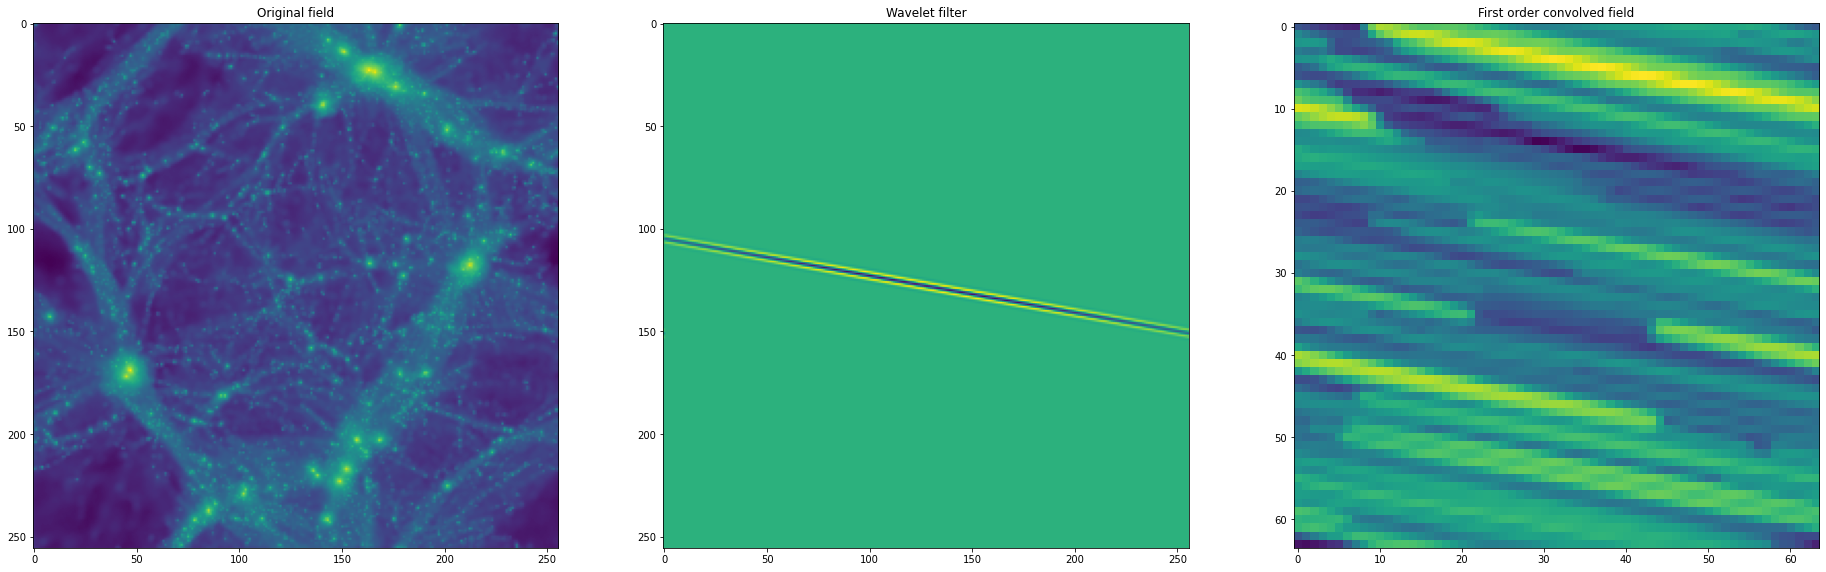

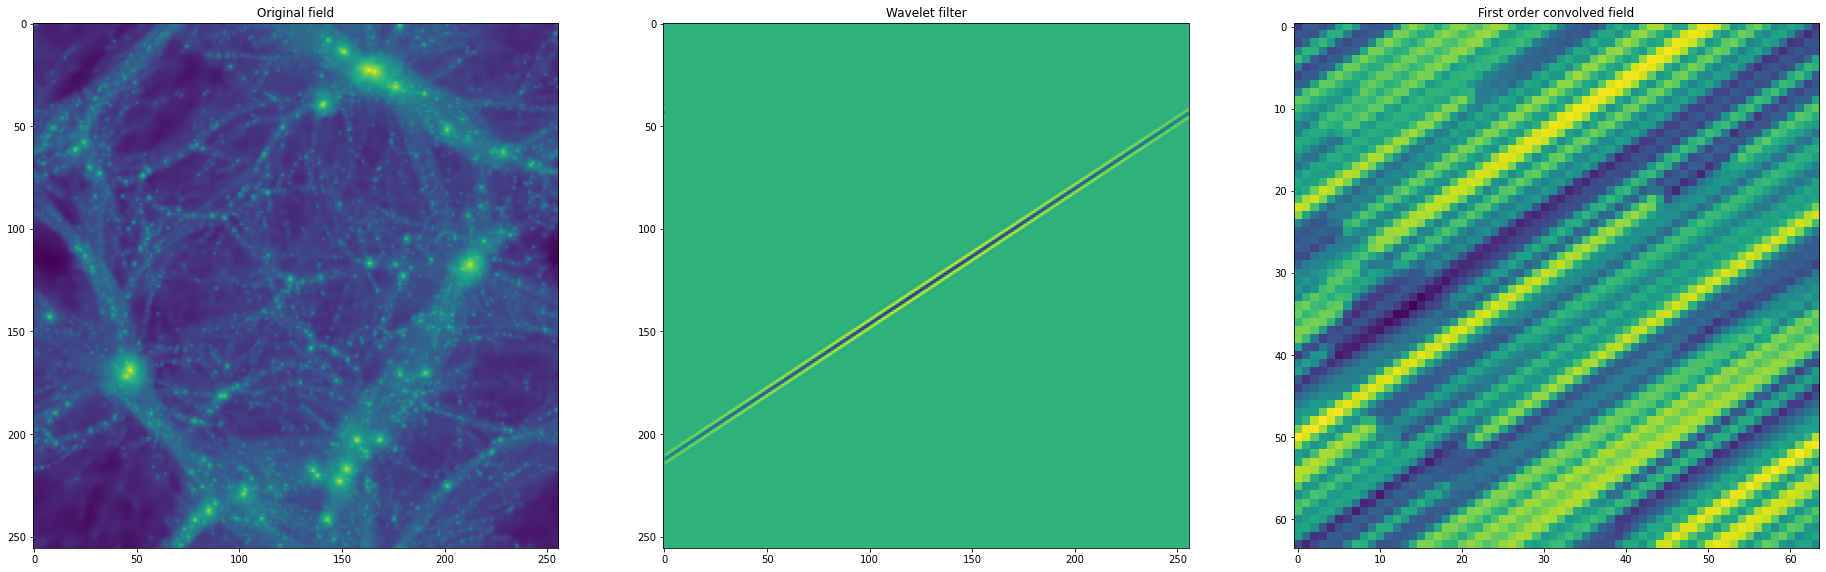

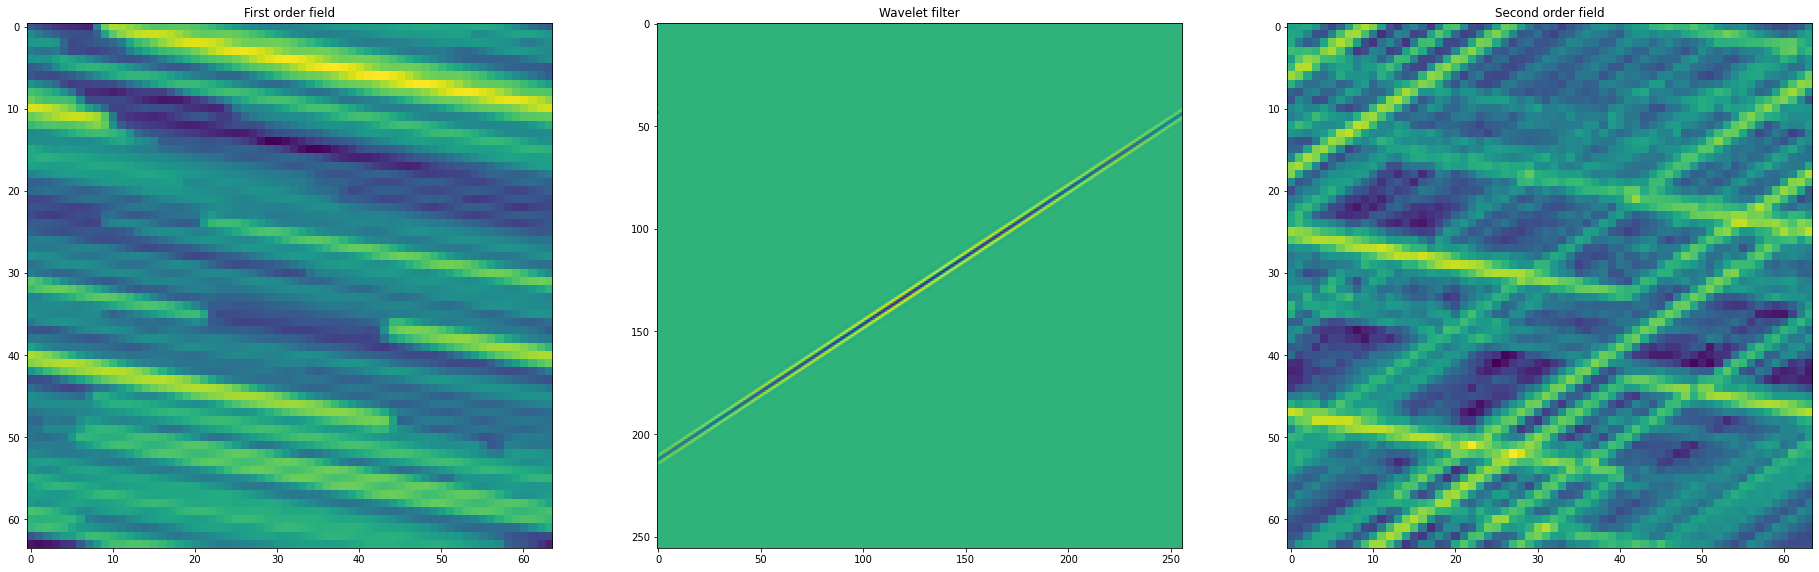

In [6]:
plot_filter(run,epoch=-1);

First order
Second order


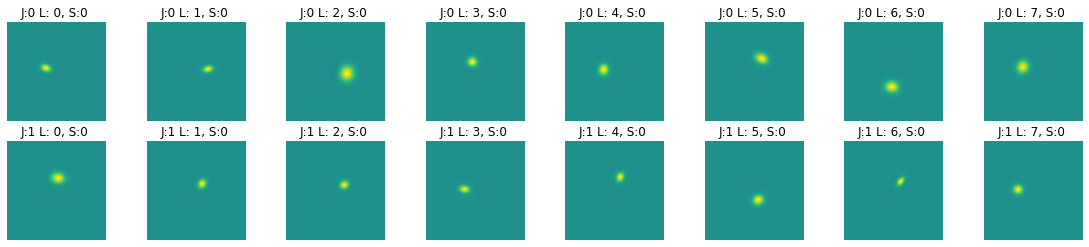

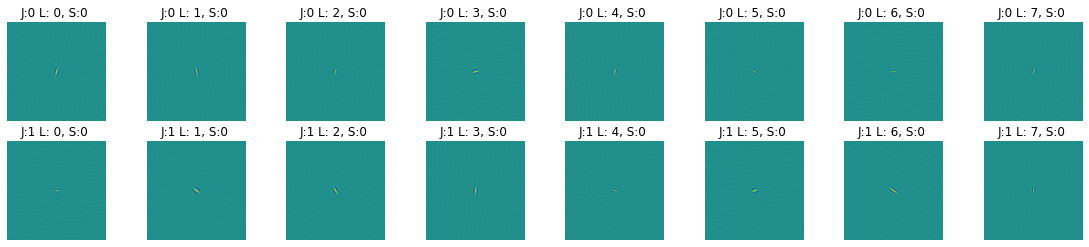

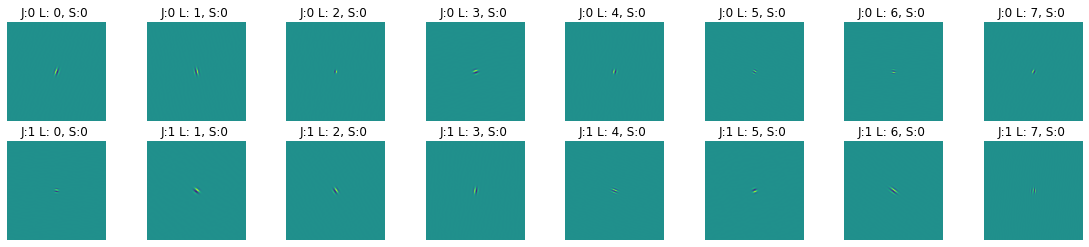

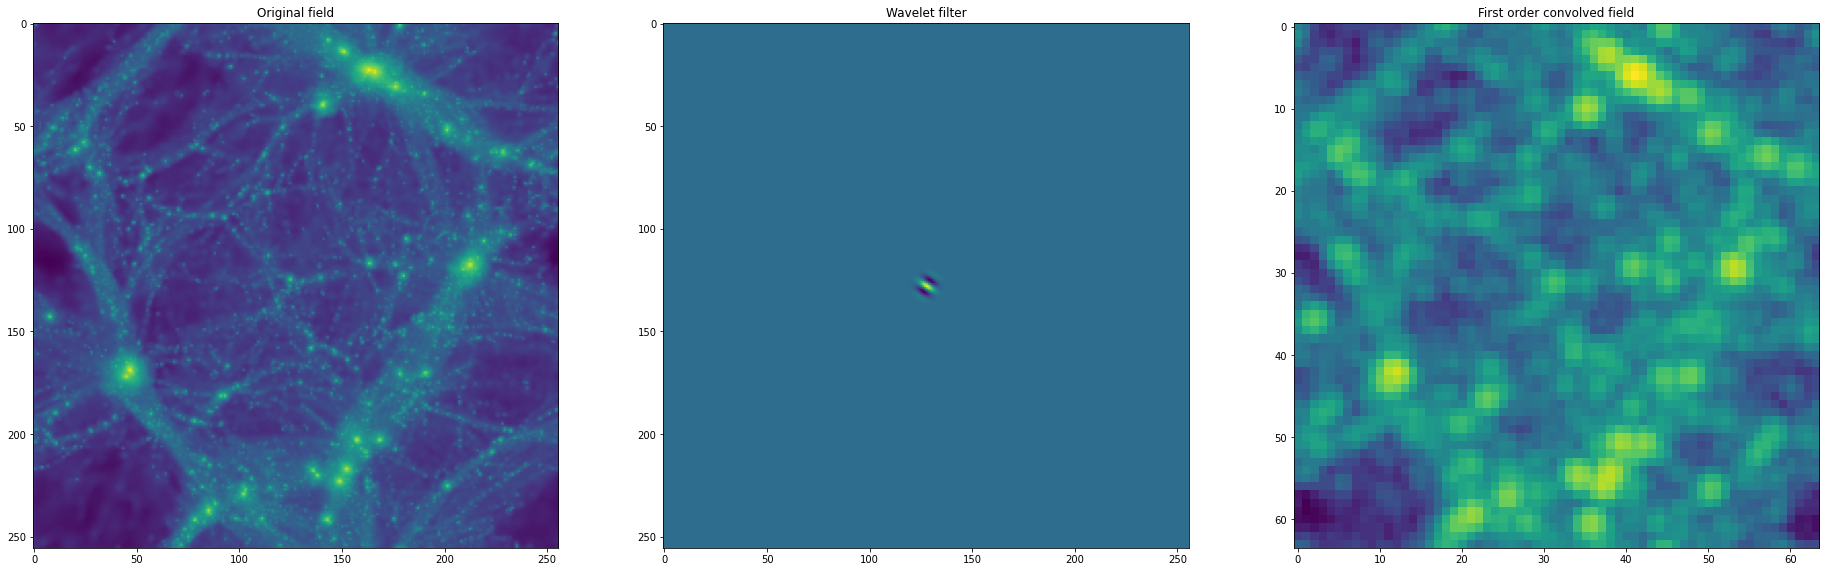

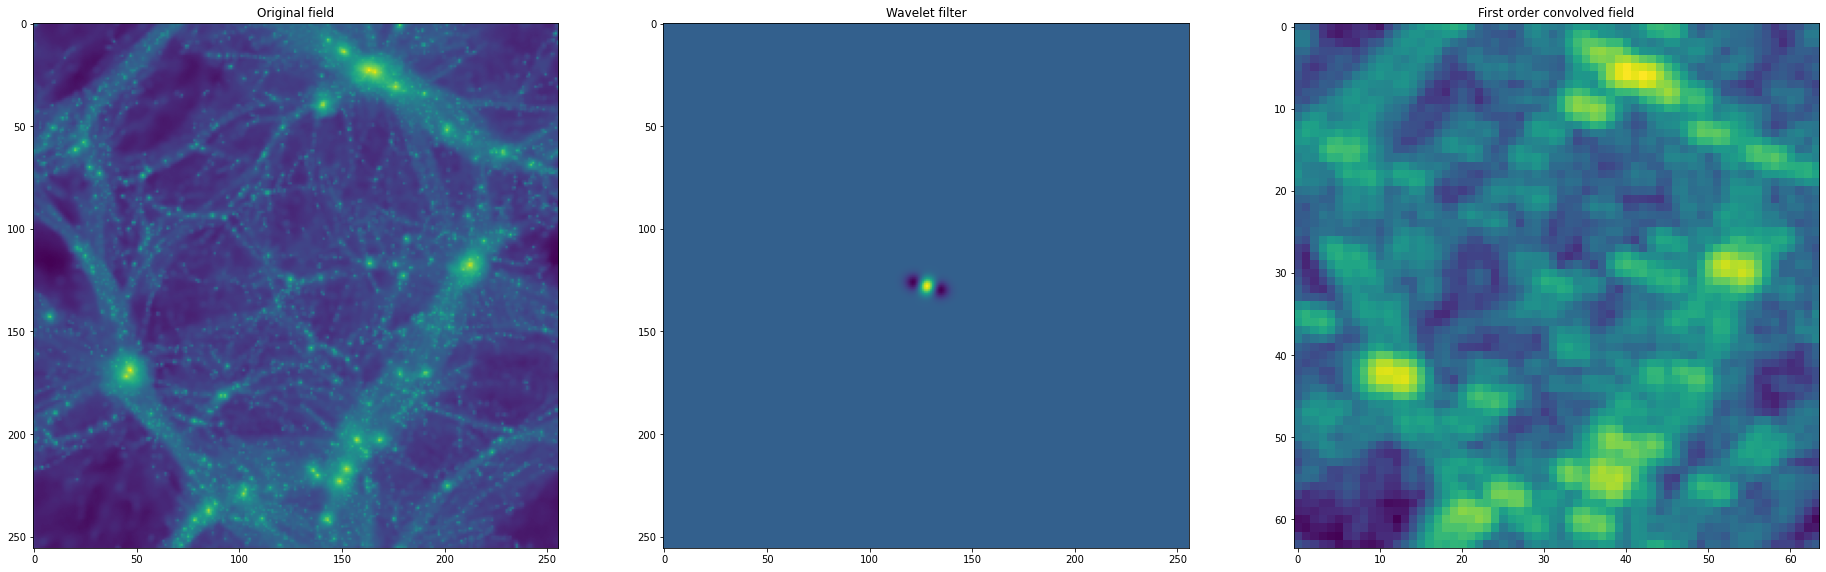

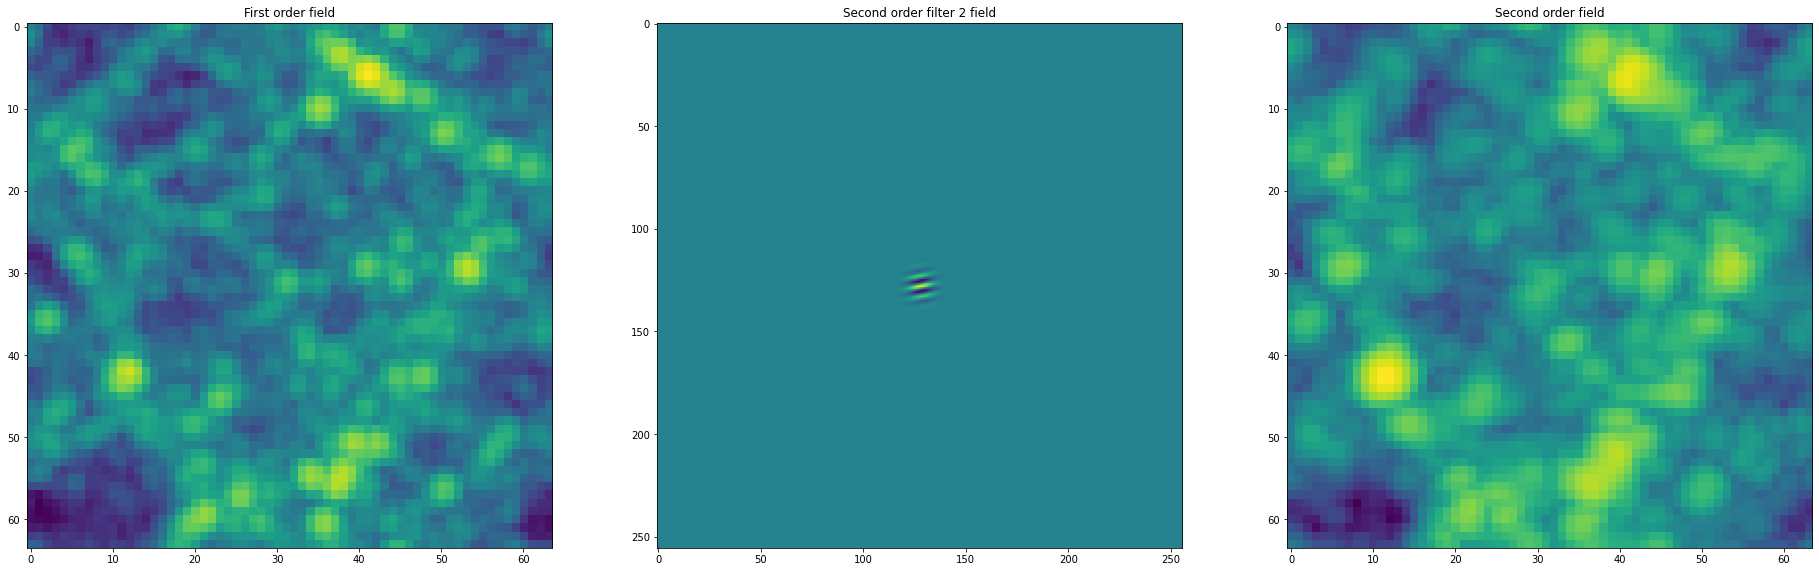

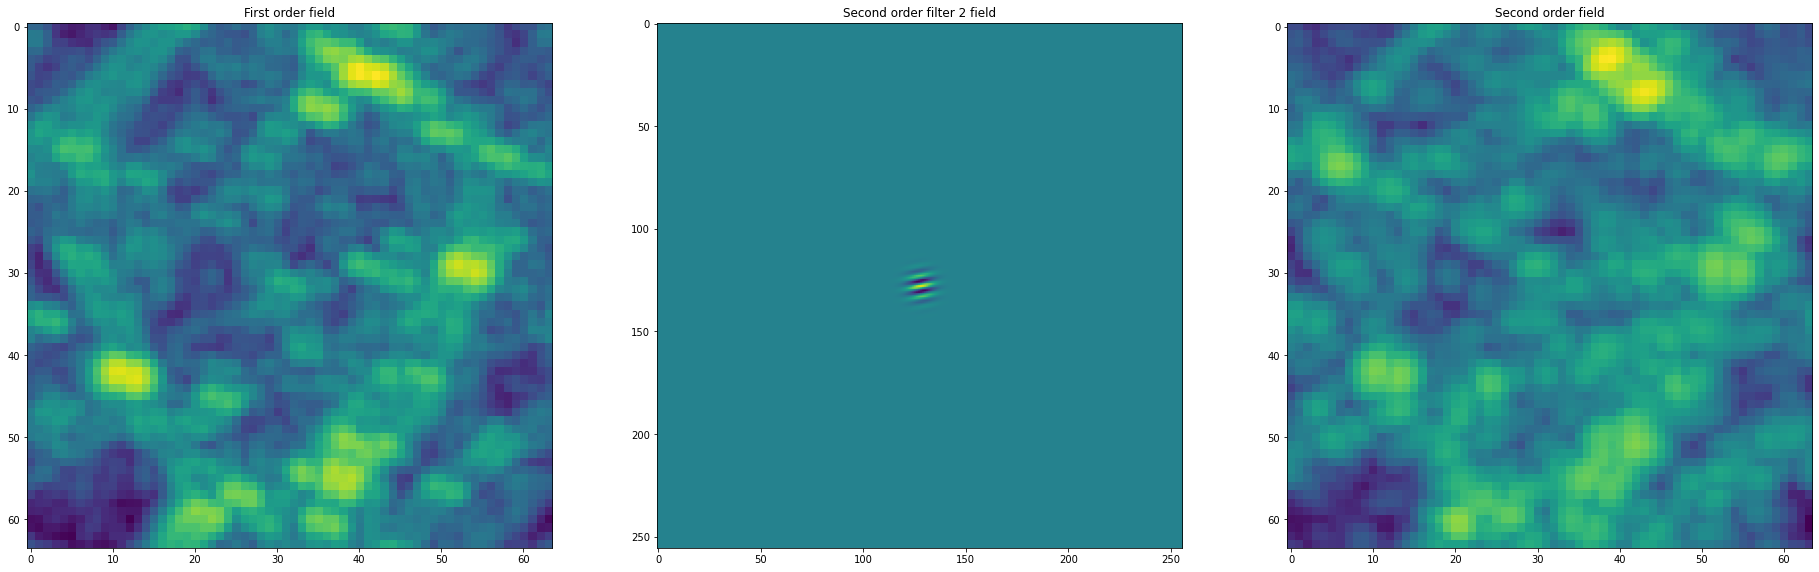

In [11]:
## Redundant - from an old run
plot_filter(run);